In [1]:
# Imports
from ypstruct import structure
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist, squareform
import re
import seaborn as sns

In [2]:
def read_TTP_instance_data(file_path):
    nb_items = int(file_path.split("-")[1].strip("n").split(".txt")[0])
    nb_cities = int(re.sub("\D", "", file_path.split("-")[0].split("/")[2]))
    # Read node coordinates from the file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Initialize variables
    node_coordinates = []
    item_values = []
    item_weights= []
    in_node_section = False
    in_item_section = False
    item_to_city_mapping_dict = {}
    v_min = None
    v_max = None
    max_capacity = None
    renting_ratio = None

    for i in range(nb_cities):
        item_to_city_mapping_dict[i] = []

    # Extract node coordinates and item data
    for line in lines:
        if line.startswith("CAPACITY OF KNAPSACK"):
            max_capacity = int(line.strip().split()[3])
            continue
        elif line.startswith("MIN SPEED"):
            v_min = float(line.strip().split()[2])
        elif line.startswith("MAX SPEED"):
            v_max = float(line.strip().split()[2])
        elif line.startswith("RENTING RATIO"):
            renting_ratio = float(line.strip().split()[2])
        elif line.startswith('NODE_COORD_SECTION'):
            in_node_section = True
            in_item_section = False
            continue
        elif line.startswith('ITEMS SECTION'):
            in_node_section = False
            in_item_section = True
            continue
        elif line.startswith('EOF'):
            break
        
        if in_node_section:
            _, x, y = map(int, line.strip().split())
            node_coordinates.append((x, y))
        elif in_item_section:
            item_id, profit, weight, node_number = map(int, line.strip().split())
            item_to_city_mapping_dict[node_number - 1].append(item_id-1) # re-index to 0
            item_values.append(profit)
            item_weights.append(weight)
    
    value_to_weight_ratio = np.array(item_values) / np.array(item_weights)
    value_to_weight_ratio_dict = {}
    for i in range(len(value_to_weight_ratio)):
        value_to_weight_ratio_dict[i] = value_to_weight_ratio[i]
    
    return {"nb_cities": nb_cities,
            "nb_items": nb_items,
            "Q": max_capacity, 
            "v_min": v_min, 
            "v_max": v_max, 
            "R": renting_ratio, 
            "pairwise_distances": pdist(node_coordinates), 
            "item_to_city_mapping":item_to_city_mapping_dict,
            "item_weights": np.array(item_weights),
            "item_values": np.array(item_values),
            "value_to_weight_ratio_dict": value_to_weight_ratio_dict
            }

#### Replicating the example evaluation of a candidate solution found in as found https://link.springer.com/chapter/10.1007/978-3-319-54157-0_4

Setting up the problem example

In [3]:
item_values = np.array([30, 34, 40, 25])
item_weights = np.array([25, 30, 40, 21])

item_to_city_mapping_dict = {0:[0], 1:[1], 2:[2], 3:[3]}
distance_matrix = np.array(
    [
    [0, 4, 9, 3],
    [4, 0, 5, 5],
    [9, 5, 0, 8],
    [3, 5, 8, 0]
    ]
).astype(float)

vmax = 1.0
vmin = 0.1
Q = 80

In [4]:
ex_node_coords = [(5, 5), (9, 5), (13, 2), (5, 2)]

In [5]:
dist_mat = squareform(pdist(ex_node_coords))
dist_mat

array([[0.        , 4.        , 8.54400375, 3.        ],
       [4.        , 0.        , 5.        , 5.        ],
       [8.54400375, 5.        , 0.        , 8.        ],
       [3.        , 5.        , 8.        , 0.        ]])

Cost function for the knapsack, as given by:
$$
  \sum^m_{j = 1} z_j * b_j
$$
where $z_j$ is the a binary vector where each index corresponds to an item and is 0 if the item is not picked and 1 if it is and $b_j$ is the values vector.

In [6]:
def knapsack_cost(candidate_solution, item_values):
    return np.sum(np.array(candidate_solution.packing_plan) * item_values)

Cost function for the tour, taking into account velocity, as given by:
$$
    f(\pi, z) = \frac{d_{\pi_1, \pi_{n}} * R}{v(w(\pi_{n}))} + \sum^{n-1}_{i = 1} \frac{d_{\pi_i, \pi_{i+1}} * R}{v(w(\pi_{i}))}
$$ 
where 
$$
    w(\pi_i) = \sum^{i}_{k=1}\sum^{m}_{j=1} z_j * b_j * a_{j, \pi_i}
$$ 

and 
$$
    v(q) = v_{max} - \frac{q}{Q} * (v_{max} - v_{min})
$$ 

where $d_{\pi_i, \pi_{i+1}}$ is the distance between city $i$ and $i+1$, obtained from the distance matrix $d$ and $a$ is the item mapping matrix and R is the renting ratio

In [63]:
def tour_cost(candidate_solution, distance_matrix, item_to_city_mapping_dict, item_weights, vmax, vmin, Q, renting_ratio):
    tour = candidate_solution.tour
    
    # calculate the weight picked up at each city
    weight_at_city_i = []
    for city in tour:
        # Create a row filled with zeros for the selected item
        item_city_row = np.zeros(len(item_weights), dtype=int)
        items_in_city = item_to_city_mapping_dict[city]
        # Fill in the row based on the item to city mapping for the selected item
        item_city_row[items_in_city] = 1
        print(item_city_row)
        weight_at_city_i.append(sum(item_city_row * np.array(candidate_solution.packing_plan) * item_weights))
    # calculate the total weight that the thief has when leaving each city using the cumulative sum 
    weight_at_city_i = np.array(np.cumsum(weight_at_city_i))
    # calculate the velocity of the thief when leaving each city
    velocity_at_city_i = vmax - weight_at_city_i / Q * (vmax - vmin)
    # retrieve the distance between the cities 
    distance_between_cities = []


    for i in range(0, len(tour)-1):

        distance_between_cities.append(distance_matrix[tour[i]][tour[i+1]])
    distance_between_cities.append(distance_matrix[tour[0]][tour[-1]])
    distance_between_cities = np.array(distance_between_cities)
    
    # return the total completion time
    return np.sum(distance_between_cities / velocity_at_city_i) * renting_ratio

In [65]:
def get_pdist_distance(pairwise_distances, i, j, nb_cities):
     if i < j:
        return pairwise_distances[nb_cities * i + j - ((i + 2) * (i + 1)) // 2]
     elif i > j:
        return pairwise_distances[nb_cities * j + i - ((j + 2) * (j + 1)) // 2]


In [69]:
def tour_cost_pdist(candidate_solution, pairwise_distances, item_to_city_mapping_dict, item_weights, vmax, vmin, Q, renting_ratio):
    tour = candidate_solution.tour
    nb_cities = len(item_weights)
    # calculate the weight picked up at each city
    weight_at_city_i = []
    for city in tour:
        # Create a row filled with zeros for the selected item
        item_city_row = np.zeros(len(item_weights), dtype=int)
        items_in_city = item_to_city_mapping_dict[city]
        print(items_in_city)
        # Fill in the row based on the item to city mapping for the selected item
        item_city_row[items_in_city] = 1

        weight_at_city_i.append(sum(item_city_row * np.array(candidate_solution.packing_plan) * item_weights))
    # calculate the total weight that the thief has when leaving each city using the cumulative sum 
    weight_at_city_i = np.array(np.cumsum(weight_at_city_i))
    # calculate the velocity of the thief when leaving each city
    velocity_at_city_i = vmax - weight_at_city_i / Q * (vmax - vmin)
    # retrieve the distance between the cities 
    distance_between_cities = []


    for i in range(0, len(tour)-1):
        distance_between_cities.append(get_pdist_distance(pairwise_distances, tour[i], tour[i+1], nb_cities))
    distance_between_cities.append(get_pdist_distance(pairwise_distances, tour[0], tour[-1], nb_cities))
    distance_between_cities = np.array(distance_between_cities)
    
    # return the total completion time
    return np.sum(distance_between_cities / velocity_at_city_i) * renting_ratio

In [11]:
def evaluate_candidate_solution_cost(candidate_solution, distance_matrix, item_to_city_mapping_dict, item_weights, item_values, vmax, vmin, Q, renting_ratio):
    candidate_solution.tour_cost = tour_cost(candidate_solution, distance_matrix, item_to_city_mapping_dict, item_weights, vmax, vmin, Q, renting_ratio)
    candidate_solution.packing_plan_cost = knapsack_cost(candidate_solution, item_values)
    return candidate_solution

In [12]:
def evaluate_candidate_solution_cost_pdist(candidate_solution, pairwise_distances, item_to_city_mapping_dict, item_weights, item_values, vmax, vmin, Q, renting_ratio):
    candidate_solution.tour_cost = tour_cost_pdist(candidate_solution, pairwise_distances, item_to_city_mapping_dict, item_weights, vmax, vmin, Q, renting_ratio)
    candidate_solution.packing_plan_cost = knapsack_cost(candidate_solution, item_values)
    return candidate_solution

Setting up the example candidate solutions and evaluating them using the previously defined function

In [13]:
ex_tours = [[1, 2, 3, 4], [1, 4, 3, 2], [1, 2, 3, 4], [1, 4, 3, 2], [1, 4, 3, 2], [1, 3, 2, 4],  [1, 4, 3, 2], [1, 2, 3, 4], [1, 4, 3, 2], [1, 3, 2, 4]]
ex_packing_plans = [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 1], [0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 1], [1, 1, 0, 0], [0, 0, 1, 1], [0, 1, 1, 0], [1, 1, 0, 1]]

In [66]:
ex_init_pop = []
for i in range(len(ex_tours)):
    candidate_solution = structure()
    candidate_solution.tour = list(np.array(ex_tours[i])-1)
    candidate_solution.packing_plan = ex_packing_plans[i]
    evaluate_candidate_solution_cost(candidate_solution, distance_matrix, item_to_city_mapping_dict, item_weights, item_values, vmax, vmin, Q, 1)
    ex_init_pop.append(candidate_solution)
ex_init_pop

[1 0 0 0]
[0 1 0 0]
[0 0 1 0]
[0 0 0 1]
[1 0 0 0]
[0 0 0 1]
[0 0 1 0]
[0 1 0 0]
[1 0 0 0]
[0 1 0 0]
[0 0 1 0]
[0 0 0 1]
[1 0 0 0]
[0 0 0 1]
[0 0 1 0]
[0 1 0 0]
[1 0 0 0]
[0 0 0 1]
[0 0 1 0]
[0 1 0 0]
[1 0 0 0]
[0 0 1 0]
[0 1 0 0]
[0 0 0 1]
[1 0 0 0]
[0 0 0 1]
[0 0 1 0]
[0 1 0 0]
[1 0 0 0]
[0 1 0 0]
[0 0 1 0]
[0 0 0 1]
[1 0 0 0]
[0 0 0 1]
[0 0 1 0]
[0 1 0 0]
[1 0 0 0]
[0 0 1 0]
[0 1 0 0]
[0 0 0 1]


[struct({'tour': [0, 1, 2, 3], 'packing_plan': [0, 0, 0, 0], 'tour_cost': 20.0, 'packing_plan_cost': 0}),
 struct({'tour': [0, 3, 2, 1], 'packing_plan': [0, 0, 0, 0], 'tour_cost': 20.0, 'packing_plan_cost': 0}),
 struct({'tour': [0, 1, 2, 3], 'packing_plan': [0, 0, 0, 1], 'tour_cost': 20.927986906710313, 'packing_plan_cost': 25}),
 struct({'tour': [0, 3, 2, 1], 'packing_plan': [0, 1, 0, 0], 'tour_cost': 22.037735849056602, 'packing_plan_cost': 34}),
 struct({'tour': [0, 3, 2, 1], 'packing_plan': [0, 0, 1, 0], 'tour_cost': 27.363636363636363, 'packing_plan_cost': 40}),
 struct({'tour': [0, 2, 1, 3], 'packing_plan': [0, 1, 0, 1], 'tour_cost': 28.585292978476183, 'packing_plan_cost': 59}),
 struct({'tour': [0, 3, 2, 1], 'packing_plan': [1, 1, 0, 0], 'tour_cost': 32.75267284390591, 'packing_plan_cost': 64}),
 struct({'tour': [0, 1, 2, 3], 'packing_plan': [0, 0, 1, 1], 'tour_cost': 33.107207533502354, 'packing_plan_cost': 65}),
 struct({'tour': [0, 3, 2, 1], 'packing_plan': [0, 1, 1, 0], 't

In [68]:
ex_init_pop = []
for i in range(len(ex_tours)):
    candidate_solution = structure()
    candidate_solution.tour = list(np.array(ex_tours[i])-1)
    candidate_solution.packing_plan = ex_packing_plans[i]
    evaluate_candidate_solution_cost_pdist(candidate_solution, pdist(ex_node_coords), item_to_city_mapping_dict, item_weights, item_values, vmax, vmin, Q, 1)
    ex_init_pop.append(candidate_solution)
ex_init_pop

[struct({'tour': [0, 1, 2, 3], 'packing_plan': [0, 0, 0, 0], 'tour_cost': 20.0, 'packing_plan_cost': 0}),
 struct({'tour': [0, 3, 2, 1], 'packing_plan': [0, 0, 0, 0], 'tour_cost': 20.0, 'packing_plan_cost': 0}),
 struct({'tour': [0, 1, 2, 3], 'packing_plan': [0, 0, 0, 1], 'tour_cost': 20.927986906710313, 'packing_plan_cost': 25}),
 struct({'tour': [0, 3, 2, 1], 'packing_plan': [0, 1, 0, 0], 'tour_cost': 22.037735849056602, 'packing_plan_cost': 34}),
 struct({'tour': [0, 3, 2, 1], 'packing_plan': [0, 0, 1, 0], 'tour_cost': 27.363636363636363, 'packing_plan_cost': 40}),
 struct({'tour': [0, 2, 1, 3], 'packing_plan': [0, 1, 0, 1], 'tour_cost': 28.12929672379371, 'packing_plan_cost': 59}),
 struct({'tour': [0, 3, 2, 1], 'packing_plan': [1, 1, 0, 0], 'tour_cost': 32.75267284390591, 'packing_plan_cost': 64}),
 struct({'tour': [0, 1, 2, 3], 'packing_plan': [0, 0, 1, 1], 'tour_cost': 33.107207533502354, 'packing_plan_cost': 65}),
 struct({'tour': [0, 3, 2, 1], 'packing_plan': [0, 1, 1, 0], 'to

In [35]:
def random_tour(nb_cities):
    return random.sample(list(range(nb_cities)), k = nb_cities)

In [36]:
def pack_one(init_pop, item_to_city_mapping_dict):
    number_of_items = len(item_to_city_mapping_dict)
    for candidate_solution in init_pop:
        packing_plan = np.zeros(number_of_items)
        chosen_item = random.sample(list(range(number_of_items)), k = 1)
        packing_plan[chosen_item] = 1
        candidate_solution.packing_plan = list(packing_plan)
    return init_pop

In [37]:
def pack_random(init_pop, item_to_city_mapping_dict):
    number_of_items = len(item_to_city_mapping_dict)
    for candidate_solution in init_pop:
        packing_plan = [random.choice(list(range(2))) for _ in range(number_of_items)]
        candidate_solution.packing_plan = packing_plan
    return init_pop

In [44]:
def generate_initial_population(pop_size, distance_matrix, item_to_city_mapping_dict, pack_init_method, tour_init_method = "random", Q = None, value_to_weight_ratio_dict = None, item_weights = None): # Jack

    init_pop = []
    nb_cities = len(item_to_city_mapping_dict.keys())
    if tour_init_method == "random":
        for _ in range(pop_size):
            candidate_solution = structure()
            candidate_solution.tour = random_tour(nb_cities)
            init_pop.append(candidate_solution)

    if pack_init_method == "random":
        pack_random(init_pop, item_to_city_mapping_dict)
    elif pack_init_method == "pack_one":
        pack_one(init_pop, item_to_city_mapping_dict)

    return init_pop

In [39]:
a280_n1395 = read_TTP_instance_data("../data/a280-n1395.txt")

In [40]:
a280_n1395_dist_mat = squareform(a280_n1395["pairwise_distances"])

In [60]:
init_pop = generate_initial_population(1, 
                                       None, 
                                       a280_n1395["item_to_city_mapping"], 
                                       "pack_one", 
                                       "random", 
                                       a280_n1395["Q"], 
                                       a280_n1395["value_to_weight_ratio_dict"],
                                       a280_n1395["item_weights"])
init_pop

[struct({'tour': [157, 195, 206, 93, 241, 276, 59, 23, 204, 250, 267, 191, 57, 135, 82, 112, 152, 4, 22, 28, 235, 170, 56, 134, 213, 7, 154, 155, 72, 225, 0, 77, 183, 156, 136, 8, 166, 278, 117, 142, 143, 58, 96, 149, 100, 90, 10, 238, 168, 97, 79, 272, 64, 139, 138, 207, 184, 106, 257, 231, 200, 70, 239, 21, 185, 215, 29, 118, 91, 175, 144, 124, 242, 243, 123, 261, 1, 164, 251, 32, 255, 153, 245, 94, 128, 232, 208, 9, 147, 180, 230, 116, 39, 131, 34, 205, 199, 99, 73, 53, 277, 55, 63, 269, 214, 95, 129, 69, 233, 2, 234, 226, 12, 105, 176, 274, 76, 146, 68, 44, 52, 266, 81, 42, 113, 111, 47, 80, 11, 268, 43, 26, 84, 140, 92, 115, 30, 177, 249, 31, 75, 178, 258, 41, 221, 3, 78, 240, 262, 209, 218, 151, 89, 86, 121, 159, 264, 137, 186, 244, 254, 14, 246, 125, 192, 50, 88, 259, 24, 141, 66, 263, 130, 211, 127, 224, 150, 189, 158, 212, 167, 46, 223, 216, 163, 198, 101, 109, 174, 217, 108, 114, 227, 236, 36, 104, 219, 87, 71, 5, 260, 48, 194, 35, 253, 179, 202, 148, 60, 187, 252, 13, 18, 12

In [61]:
np.array(init_pop[0].packing_plan)[np.array(init_pop[0].packing_plan) > 0]

array([1.])

In [67]:
evaled_pop = [
    evaluate_candidate_solution_cost_pdist(candidate_solution,
                                     a280_n1395["pairwise_distances"],
                                     a280_n1395["item_to_city_mapping"],
                                     a280_n1395["item_weights"],
                                     a280_n1395["item_values"],
                                     a280_n1395["v_max"],
                                     a280_n1395["v_min"],
                                     a280_n1395["Q"],
                                     a280_n1395["R"])
    for candidate_solution in init_pop
]



ValueError: operands could not be broadcast together with shapes (1395,) (280,) 

In [110]:
def get_ranks(population): # Ursula
    # return (rank, structure()) or candidate solution object as represented above with an additional "rank" attribute
    # doesn't need to return anything if only adding "rank" attribute to candidate solution.
    # Probs easier for later functions if just add crowding_distance attribute to candidate solution
    #Current front set
    f = []
    #Sets for the entire population
    big_s = []
    #dominant individuals for the entire population
    big_np = []
    for p in population:
        #S is the set of individuals that are dominated by p
        s = []
        #np = the number of individuals that dominate p
        np = 0
        for q in population:
            if q.packing_plan_cost < p.packing_plan_cost and q.tour_cost >= p.tour_cost:
                s.append(q)
            elif q.packing_plan_cost <= p.packing_plan_cost and q.tour_cost > p.tour_cost:
                s.append(q)
            elif q.packing_plan_cost > p.packing_plan_cost and q.tour_cost <= p.tour_cost:
                np +=1
            elif q.packing_plan_cost >= p.packing_plan_cost and q.tour_cost < p.tour_cost:
                np +=1
        if np == 0:
            p.rank = 1
            f.append(p)
    
        big_s.append(s)
        big_np.append(np)
    front_counter = 1
    while len(f) != 0:
        #individuals from the i+1 front
        q = []
        for y in f:
            for x in big_s[population.index(y)]:
                big_np[population.index(x)] -= 1
                if big_np[population.index(x)] == 0:
                    x.rank = front_counter+1
                    q.append(x)
        front_counter += 1
        f = q
    return None

In [111]:
get_ranks(evaled_pop)

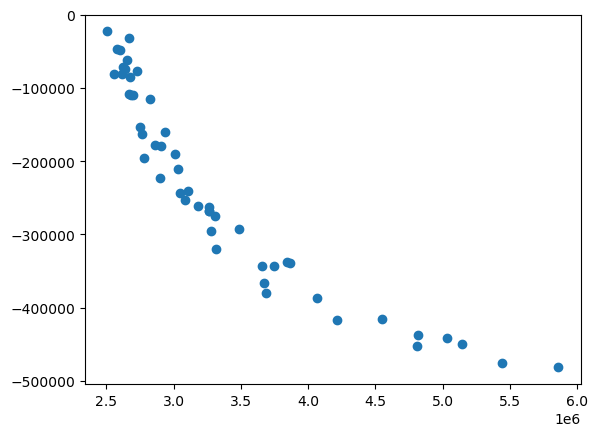

In [112]:
plt.scatter([sol.tour_cost for sol in evaled_pop], [-1 * sol.packing_plan_cost for sol in evaled_pop])

In [113]:
import pandas as pd
df = pd.DataFrame()
df['tour_cost'] = [sol.tour_cost for sol in evaled_pop]
df['packing_plan_cost'] = [-1 * sol.packing_plan_cost for sol in evaled_pop]
df["rank"] = [sol.rank for sol in evaled_pop]
print(df)

       tour_cost  packing_plan_cost  rank
0   3.047825e+06          -243340.0     1
1   5.029504e+06          -441163.0     2
2   4.806951e+06          -453093.0     1
3   4.062648e+06          -386577.0     1
4   2.901403e+06          -222971.0     1
5   2.599779e+06           -48165.0     2
6   2.726989e+06           -77668.0     3
7   3.264844e+06          -267876.0     2
8   3.262087e+06          -263189.0     1
9   3.184241e+06          -260835.0     1
10  3.006704e+06          -190241.0     2
11  2.907206e+06          -179068.0     2
12  3.743695e+06          -343204.0     2
13  2.623220e+06           -71079.0     2
14  3.861795e+06          -339641.0     3
15  2.653748e+06           -61616.0     3
16  3.279397e+06          -294799.0     1
17  2.559975e+06           -80474.0     1
18  2.638512e+06           -73905.0     2
19  3.657906e+06          -343204.0     1
20  3.304068e+06          -274876.0     2
21  5.145903e+06          -449561.0     2
22  5.856825e+06          -481523.

<Axes: xlabel='tour_cost', ylabel='packing_plan_cost'>

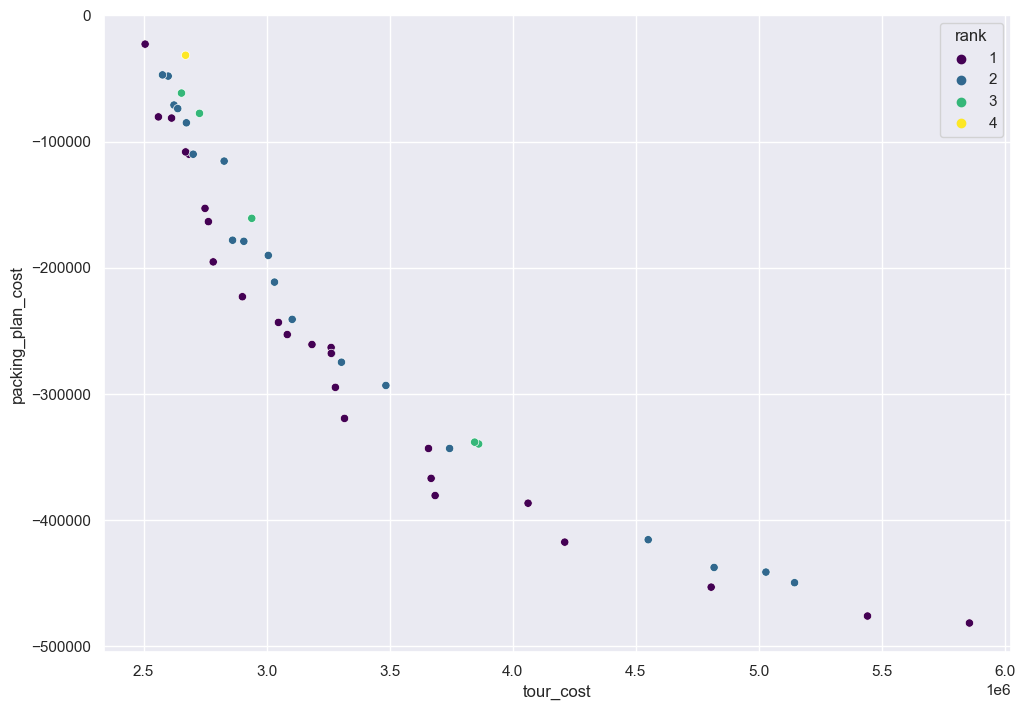

In [120]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x='tour_cost', y='packing_plan_cost', data=df, hue='rank',palette = "viridis")

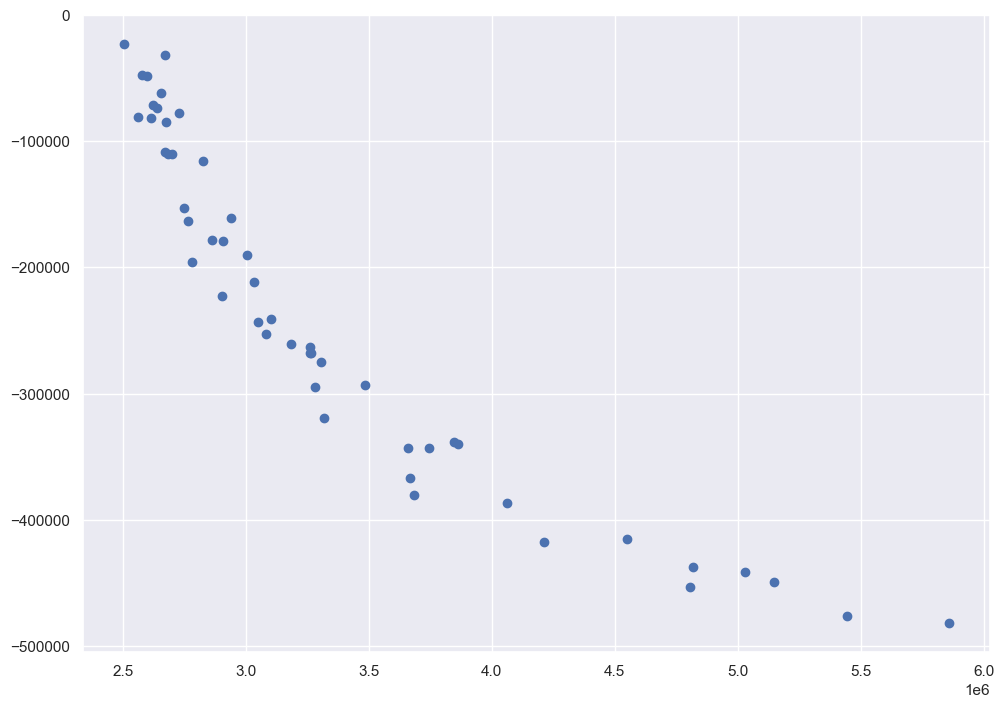

In [117]:
plt.scatter([sol.tour_cost for sol in evaled_pop], [-1 * sol.packing_plan_cost for sol in evaled_pop])

In [156]:
init_pop.index(init_pop[1])

1

In [157]:
ex_sol = ex_init_pop[1]

In [158]:
ex_init_pop[1] == ex_init_pop[1]

True

In [159]:
code = "yes"
number = "no"
yes = "yes"
l = [code, number, yes]
l.index("yes")

0

In [160]:
ex_init_pop.index(ex_init_pop[1])

1

In [ ]:
def find_min_indices_in_row(matrix, row_index):
    row = matrix[row_index, :]
    min_value = np.min(row)
    min_indices = np.where(row == min_value)

    if len(min_indices[0]) == 1:
        # If there's a single minimum value, return only its index in the specified row
        return [min_indices[0][0]]
    else:
        # If there are duplicates, return all occurrences within the specified row
        return [col_index for col_index in min_indices[0]]


In [ ]:
def nearest_neighbour(distance_matrix):
    dist_matrix = distance_matrix.copy()
    num_cities = dist_matrix.shape[0]
    start_city = random.sample(list(range(num_cities)), k = 1)
    dist_matrix[:, start_city[0]] = np.inf

    for _ in range(1, num_cities):
        current_city = start_city[-1]
        next_city = random.sample(find_min_indices_in_row(dist_matrix, current_city), k = 1)[0]
        start_city.append(next_city)
        dist_matrix[:, next_city] = np.inf
    
    return start_city

        

In [ ]:
def tour_length(tour, distance_matrix: list[list]) -> float:
    
    # cost of going from last city in the chromosme back to the starting chromosome
    return_to_start_length = distance_matrix[len(distance_matrix)-1][tour[0]]
    # calculate the cost for the rest of the tour
    travel_length = 0
    for i in range(0, len(distance_matrix)-1, 1):
        travel_length += distance_matrix[tour[i]][tour[i+1]]

    return travel_length + return_to_start_length


In [ ]:
def nearest_neighbour_2opt(distance_matrix):
    tour = nearest_neighbour(distance_matrix=distance_matrix)
    number_of_cities = distance_matrix.shape[0]
    max_2opt_moves = (number_of_cities) * (number_of_cities - 1) / 2
    made_moves = []
    length = tour_length(tour, distance_matrix)
    better = False
    i = 0 

    while not better and i < max_2opt_moves:
        i += 1
        idx = range(len(tour))
        made_move = False
        i1, i2 = (None, None)
        while not made_move:
            i1_test, i2_test = random.sample(idx, 2)
            if (i1_test, i2_test) in made_moves or (i2_test, i1_test) in made_moves:
                continue
            else:
                i1, i2 = i1_test, i2_test
                made_move = True
        made_moves.append((i1, i2))
        made_moves.append((i2, i1))
        new_tour = tour.copy()
        new_tour[i1], new_tour[i2] = new_tour[i2], new_tour[i1]
        if tour_length(new_tour, distance_matrix) < length:
            better = True
            tour = new_tour
    return tour


   

In [ ]:
def pack_optimal(init_pop, item_to_city_mapping_dict, Q, value_to_weight_ratio_dict, item_weights):

    number_of_items = len(item_weights)
    
    sorted_value_to_weight_ratio_dict = dict(sorted(value_to_weight_ratio_dict.items(), key=lambda x:x[1], reverse = True))

    for candidate_solution in init_pop:
        Q_prime = np.random.randint(low = 0, high = Q, size = 1)
        packing_plan = np.zeros(number_of_items)
        weight  = 0
        for i in range(number_of_items):
            if weight + item_weights[list(sorted_value_to_weight_ratio_dict.keys())[i]] < Q_prime:

                packing_plan[list(sorted_value_to_weight_ratio_dict.keys())[i]] = 1
                weight += item_weights[list(sorted_value_to_weight_ratio_dict.keys())[i]]
        candidate_solution.packing_plan = list(packing_plan)
    return init_pop